In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
import tqdm
import pandas as pd
import seaborn as sns
import scipy.stats as sstats
from matplotlib.lines import Line2D
from collections import defaultdict, deque

%matplotlib inline

In [2]:
class NSGA2():
    
    def __init__(self,population_size, chromosome_length, F, crossover_pbp=0.95, mutation_pbp=0.25, number_of_iterations=250):
        self.population_size = population_size
        self.chromosome_length = chromosome_length
        self.number_of_offspring = self.population_size
        self.crossover_probability = crossover_pbp
        self.mutation_probability = mutation_pbp
        self.number_of_iterations = number_of_iterations
        self.F = F
        self.current_population = self.initial_population()
        self.mutation_function = self.reverse_sequence_mutation

        self.time0 = time.time()

        self.best_objective_value = np.Inf
        self.best_ranking = np.Inf
        self.best_chromosome = np.zeros((1, self.chromosome_length))
        self.crossover_function = self.PMX
        self.ans = np.zeros((self.number_of_iterations, 6))
#         self.ans_frots = np.zeros((self.number_of_iterations, ))
        
    def PMX(self, ind1, ind2, sep_num=2):
        separators = np.random.choice(ind1, size=sep_num, replace=False)
        separators = np.sort(separators)

        ind1 = np.array(ind1)
        ind2 = np.array(ind2)
        ogind1 = ind1.copy()
        ogind2 = ind2.copy()

        separators = np.append(np.append([0],separators),[len(ind1)])
        groups1 = np.array([ind1[separators[i]:separators[i+1]] for i in range(len(separators)-1)])
        groups2 = np.array([ind2[separators[i]:separators[i+1]] for i in range(len(separators)-1)])
        main_group_id = np.random.randint(0,len(groups1))
        main_group = groups1[main_group_id]
        gr1_into_gr2 = dict()
        for e in ind1:
            gr1_into_gr2[e] = e

        gr2_into_gr1 = dict()
        for e in ind2:
            gr2_into_gr1[e] = e

        new_groups1 = groups1.copy()
        new_groups1[main_group_id] = groups2[main_group_id]
        for i,e in enumerate(new_groups1[main_group_id]):
            gr1_into_gr2[e] = groups1[main_group_id][i]

        new_groups2 = groups2.copy()
        new_groups2[main_group_id] = groups1[main_group_id]
        for i,e in enumerate(new_groups2[main_group_id]):
            gr2_into_gr1[e] = groups2[main_group_id][i]

        # filling other groups
        for i, g in enumerate(new_groups1):
            if main_group_id != i:
                for j, element in enumerate(g):
                    if element in groups2[main_group_id]:
                        g[j] = -1
                    else:
                        g[j] = gr1_into_gr2[element]

        for i, g in enumerate(new_groups2):
            if main_group_id != i:
                for j, element in enumerate(g):
                    if element in groups1[main_group_id]:
                        g[j] = -1
                    else:
                        g[j] = gr2_into_gr1[element]
        O1 = np.concatenate(new_groups1)
        O2 = np.concatenate(new_groups2)

        # O1
        ind_covered1 = set(O1)
        ind_covered1 = set(ogind1).difference(ind_covered1)
        if -1 in ind_covered1:
            ind_covered1.remove(-1)

        for i,elem in enumerate(O1):
            if elem == -1:
                O1[i] = ind_covered1.pop()
        # O2      
        ind_covered2 = set(O2)
        ind_covered2 = set(ogind2).difference(ind_covered2)
        if -1 in ind_covered2:
            ind_covered2.remove(-1)

        for i,elem in enumerate(O2):
            if elem == -1:
                O2[i] = ind_covered2.pop()

        return O1, O2
    
    def plot_values(self):
        plt.figure()
        plt.plot(self.ans.T[2].T,color='green',label='min')
        plt.plot(self.ans.T[3].T,color='blue',label='mean')
        plt.plot(self.ans.T[4].T,color='red',label='max')
        plt.legend()
        plt.show()

    # generating an initial population
    def initial_population(self):
        current_population = np.zeros((self.population_size, self.chromosome_length), dtype=np.int64)
        for i in range(self.population_size):
            current_population[i, :] = np.random.permutation(self.chromosome_length)
        return current_population
    
    def reverse_sequence_mutation(self, p):
        a = np.random.choice(len(p), 2, False)
        i, j = a.min(), a.max()
        q = p.copy()
        q[i:j+1] = q[i:j+1][::-1]
        return q
    
    def two_swapped_mutation(self, p):
        inds = np.random.randint(0,len(p), size=2)
        q = p.copy()
        q[inds[0]] = p[inds[1]]
        q[inds[1]] = p[inds[0]]
        return q
    
    def evaluate_obj_functions(self):
        for i in range(self.population_size):
            objective_values[i] = self.F(self.current_population[i, :])
            
    def fast_nominated_sort(self, pop):
        pass
    
    def select_parents_by_rank(self):
        pass
    
    def pareto_fronts2(self, obj_vals):
        dominant_count = np.zeros(self.population_size).astype(int)
        dominates = defaultdict(set)
        fronts = np.full(self.population_size, None)
        
        for i, vals1 in enumerate(obj_vals):
            for j, vals2 in enumerate(obj_vals):
                if j < i:
                    continue

                if np.all(vals1 <= vals2) and np.any(vals1 < vals2):
                    dominant_count[j] += 1
                    dominates[i].add(j)
                elif np.all(vals1 >= vals2) and np.any(vals1 > vals2):
                    dominant_count[i] += 1
                    dominates[j].add(i)
        
        cur_pareto = 0
        fronts[np.nonzero(dominant_count == 0)[0]] = cur_pareto
        from_pareto = np.nonzero(fronts == 0)[0]
        
        while len(from_pareto):
            dominant_count[from_pareto] = -1
            cur_pareto += 1
            for i in from_pareto:
                if len(dominates[i]) == 0:
                    continue
                dominant_count[np.array(list(dominates[i]))] -= 1
                fronts[np.nonzero(dominant_count == 0)[0]] = cur_pareto
            from_pareto = np.nonzero(fronts == cur_pareto)[0]
        
        return fronts
    
    def pareto_fronts(self, obj_v):
        # front[index] = (N_count, set(S))
        fronts = {}
        for i in range(len(obj_v)):
            for j in range(len(obj_v)):
                if np.all(obj_v[i] <= obj_v[j]) and np.any(obj_v[i] < obj_v[j]):
                    if i in fronts:
                        fronts[i][1].add(j)
                    else:
                        fronts[i] = (0, set([j]))
        Q = deque()
        current_pareto_front = 0
        for elem in fronts.items():
            k, v = elem
            if v[0] == 0:
                Q.append((k, current_pareto_front))
                
        pareto_results = defaultdict(int)
        while len(Q) > 0:
            elem = Q.pop()
            index, curr_par_front = elem
            pareto_results[index] = curr_par_front
            for a in fronts[index][1]:
                fronts[a] = fronts[a][0] - 1, fronts[a][1]
                if fronts[a][0] == 0:
                    Q.append((a, curr_par_front+1))
        return pareto_results
    
    def rank_comparator(self, ind1, ind2, pareto_res):
        if pareto_res[ind1] < pareto_res[ind2]:
            return ind1
        elif pareto_res[ind1] > pareto_res[ind2]:
            return ind2
        else:
            return ind1
    
    def crowding_distance(self, pareto_res, ind):
        same_front = np.array([inds for inds in range(self.population_size) if pareto_res[inds] == ind])
#         np.delete(same_front, ind)
        manhatan_bigger = np.Inf
        manhatan_smaller = -np.Inf
        for inds in same_front:
            current_manahtan = np.sum(np.abs(np.array(self.F(self.current_population[inds])) - np.array(self.F(self.current_population[ind]))))
            if current_manahtan > manhatan_smaller and self.F(self.current_population[inds])[0] < self.F(self.current_population[ind])[0] and ind != inds:
                manhatan_smaller = current_manahtan
            elif current_manahtan < manhatan_bigger and self.F(self.current_population[inds])[0] > self.F(self.current_population[ind])[0] and ind!= inds:
                manhatan_bigger = current_manahtan
        return manhatan_bigger + manhatan_smaller
            
    
    def run(self):
        time0 = time.time()
        # evaluating the objective function on the current population
        objective_values = np.zeros((self.population_size, 2))
        for i in range(self.population_size):
            objective_values[i] = self.F(self.current_population[i, :])
        
        pareto_res = self.pareto_fronts2(objective_values)
#         print(list(pareto_res))
        
        ranks = np.zeros(self.population_size)
        for ind1 in range(self.population_size):
            for ind2 in range(self.population_size):
                if pareto_res[ind1] < pareto_res[ind2]:
                    ranks[ind2] += 1
                elif pareto_res[ind1] > pareto_res[ind2]:
                    ranks[ind1] += 1
                else:
                    continue
                    if self.crowding_distance(pareto_res, ind1) < self.crowding_distance(pareto_res, ind2):
                        ranks[ind1] += 1
                    elif self.crowding_distance(pareto_res, ind1) > self.crowding_distance(pareto_res, ind2):
                        ranks[ind2] += 1
                    else:
                        ranks[ind1] += 1
        
        for t in tqdm.tqdm(range(self.number_of_iterations)):

            # selecting the parent indices by the roulette wheel method
            fitness_values = ranks.max() - ranks
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = np.ones(self.population_size) / self.population_size
            parent_indices = np.random.choice(self.population_size, self.number_of_offspring, True, fitness_values).astype(np.int64)

            # creating the children population
            children_population = np.zeros((self.number_of_offspring, self.chromosome_length), dtype=np.int64)
            for i in range(int(self.number_of_offspring/2)):
                if np.random.random() < self.crossover_probability:
                    children_population[2*i, :], children_population[2*i+1, :] = self.crossover_function(self.current_population[parent_indices[2*i], :].copy(), self.current_population[parent_indices[2*i+1], :].copy())
                else:
                    children_population[2*i, :], children_population[2*i+1, :] = self.current_population[parent_indices[2*i], :].copy(), self.current_population[parent_indices[2*i+1]].copy()

            if np.mod(self.number_of_offspring, 2) == 1:
                children_population[-1, :] = self.current_population[parent_indices[-1], :]

            # mutating the children population
            for i in range(self.number_of_offspring):
                if np.random.random() < self.mutation_probability:
                    children_population[i, :] = self.mutation_function(children_population[i, :])

            # evaluating the objective function on the children population
            children_objective_values = np.zeros((self.number_of_offspring, 2))
            for i in range(self.number_of_offspring):
                children_objective_values[i] = self.F(children_population[i, :])

            # replacing the current population by (Mu + Lambda) Replacement
            objective_values = np.hstack([objective_values, children_objective_values])
            self.current_population = np.vstack([self.current_population, children_population])
            
            pareto_res = self.pareto_fronts2(objective_values)
            ranks = np.zeros(self.population_size)
            for ind1 in range(self.population_size):
                for ind2 in range(self.population_size):
                    if pareto_res[ind1] < pareto_res[ind2]:
                        ranks[ind2] += 1
                    elif pareto_res[ind1] > pareto_res[ind2]:
                        ranks[ind1] += 1
                    else:
                        continue
                        if self.crowding_distance(pareto_res, ind1) < self.crowding_distance(pareto_res, ind2):
                            ranks[ind1] += 1
                        elif self.crowding_distance(pareto_res, ind1) > self.crowding_distance(pareto_res, ind2):
                            ranks[ind2] += 1
                        else:
                            ranks[ind1] += 1
            
            I = np.argsort(ranks)
            self.current_population = self.current_population[I[:self.population_size], :]
            objective_values = objective_values[I[:self.population_size]]
            
            if i % 25 == 0:
                resx,resy = self.F(self.current_population.T)
                plt.subplots(figsize=(12,6))
                plt.scatter(resx,resy)
                plt.show()

            # recording some statistics
#             if np.all(self.best_objective_value < objective_values[0]):
#                 self.best_objective_value = objective_values[0]
#                 best_chromosome = self.current_population[0, :]

            self.ans[t] = np.array([t, time.time() - time0, objective_values.min(), objective_values.mean(),
                                    objective_values.max(), objective_values.std()])
        return self.ans

## Test functions for multi-objective optimization

In [3]:
def binh_and_korn(x,y):
    # R 0<x<5, 0<y<3
    punishment = 10000
    res = 0
    if (x - 5) ** 2 + y ** 2 > 25:
        res += punishment
    if (x - 8) ** 2 + (y + 3)**2 < 7.7:
        res += punishment
    res_x = 4*x**2 + 4*y**2 + res
    res_y = (x-5)**2 + (y-5)**2 + res
    return res_x, res_y

In [4]:
def ZDT3(x):
    assert 1 < len(x) <= 30
    g = 1 + 9/(len(x)+1)*np.sum(x[1:])
    h = 1 - np.sqrt(x[0]/g) - (x[0]/g)*np.sin(10*np.pi*x[0])
    return x[0], g*h   

In [5]:
def pareto_test(x):
    return x[0], x[0]

In [6]:
nsga2 = NSGA2(200, 10, F=ZDT3, crossover_pbp=0.95, mutation_pbp=0.25, number_of_iterations=250)
nsga2_result = nsga2.run()

100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:03:29<00:00, 15.24s/it]


In [11]:
resx,resy = ZDT3(nsga2.current_population.T)

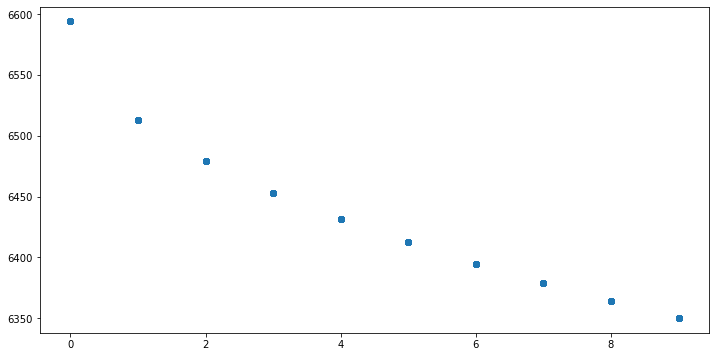

In [14]:
plt.subplots(figsize=(12,6))
plt.scatter(resx,resy)
plt.show()

In [5]:
nsga2 = NSGA2(200, 10, F=ZDT3, crossover_pbp=0.95, mutation_pbp=0.25, number_of_iterations=250)
nsga2_result = nsga2.run()

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:45<00:00,  5.54it/s]


(200,)


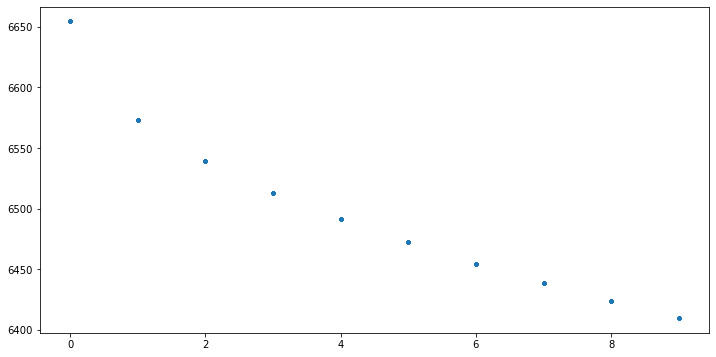

In [11]:
resx,resy = ZDT3(nsga2.current_population.T)
print(resx.shape)
plt.subplots(figsize=(12,6))
plt.scatter(resx,resy, marker='.')
plt.show()